In [1]:
from functions import *

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
connect(instruments)
reset(instruments)

In [4]:
instruments['OSC'].write("SYST:DISP:UPD 1")
instruments['DAQ'].set_conn(123)
ch_DAQ_AWG, ch_DAQ_SMU = 113, 111

## R&W

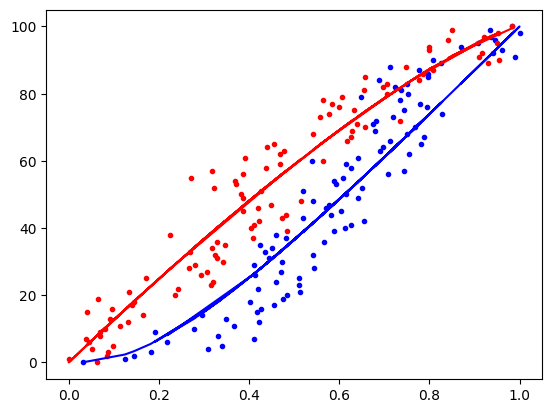

In [70]:
params_list = []
for i in range(1):
    P, R = characterize(1)
    params_list.append(get_params(P, R))

In [44]:
A = np.mean([params['A'] for params in params_list])
B = np.mean([params['B'] for params in params_list])
popt_s = np.mean([params['popt']['s'] for params in params_list], 0)
popt_r = np.mean([params['popt']['r'] for params in params_list], 0)

In [35]:
G = 0
write(params, ch_DAQ_AWG, ch_DAQ_SMU, G)
read(params, ch_DAQ_AWG, ch_DAQ_SMU)

0.22485126916925477

## AWG

In [78]:
wf_dict_AWG = {
    'V' : [2.5, -2.7], # pulse voltages
    'n' : [N, N],   # pulse repetitions
    'W' : 1e-4,     # pulse width
    'T' : 1e-3,     # pulse period
    'read' : True,
    'read_V' : .1,
    'ch' : 1
}
get_and_set_wf('AWG', wf_dict_AWG)

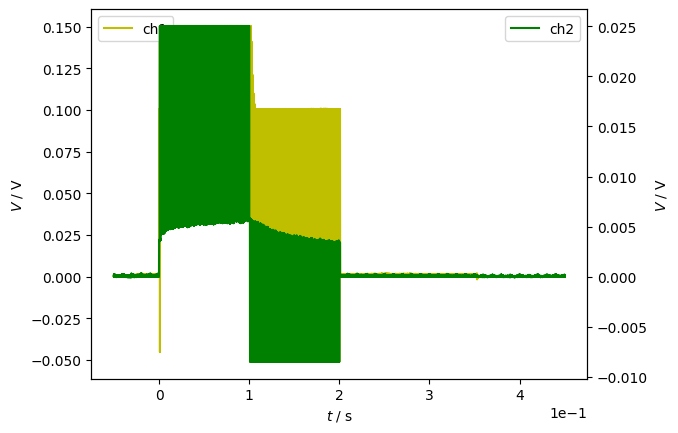

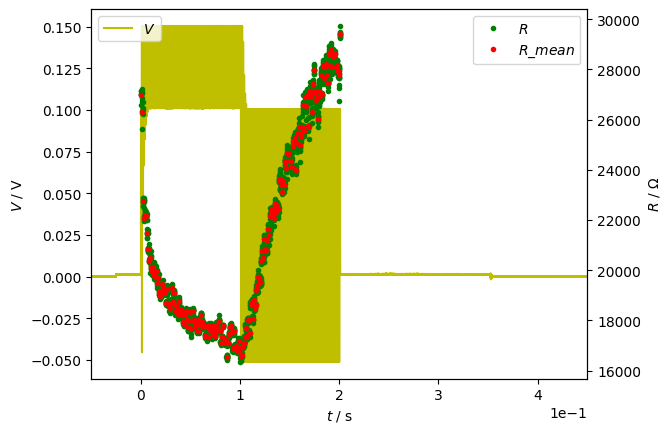

In [80]:
results_AWG = meas_AWG(ch_DAQ_AWG, wf_dict_AWG, [1, 2], R_s=1e3, R_min=5e3)

In [30]:
with open(f"meas_dict/AWG_{date.today()}.json", "r") as json_file:
    meas_dict_AWG = json.load(json_file)

## AWG_SMU

In [27]:
g = 10
T = 1e-3
W = 2e-4
wf_dict_AWG_list = [
    {
        'V' : [-2.6],
        'n' : [g],
        'T' : T,
        'W' : W,
        'read' : False,
        'read_V' : 0,
        'ch' : 1
    }, {
        'V' : [2.4],
        'n' : [g],
        'T' : T,
        'W' : W,
        'read' : False,
        'read_V' : 0,
        'ch' : 1
    }
]
wf_dict_SMU = {
    'V' : [0],
    'n' : [0],
    'T' : 1,
    'W' : 0,
    'read' : True,
    'read_V' : .1,
    'ch' : 1
}

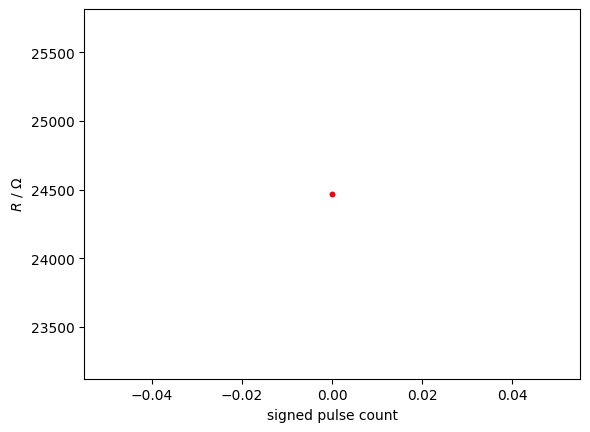

In [28]:
n = [5, 5]
#results = meas_AWG_SMU(wf_dict_AWG_list, n, ch_DAQ_AWG, ch_DAQ_SMU, wf_dict_SMU, R_s = 1e3)
results = meas_AWG_SMU([], [], ch_DAQ_AWG, ch_DAQ_SMU, wf_dict_SMU, R_s = 1e3)

## SMU

In [18]:
wf_dict_SMU = {
    'V' : [1, -1],
    'n' : [10, 10],
    'T' : 1e-2,
    'W' : 2e-3,
    'read' : True,
    'read_V' : .1,
    'ch' : 2
}
get_and_set_wf('SMU', wf_dict_SMU)

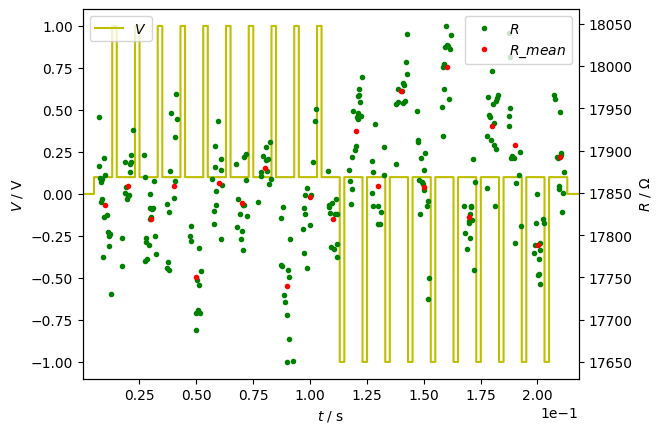

In [19]:
results_SMU = meas_SMU(ch_DAQ_SMU, wf_dict_SMU, [1, 2])

In [40]:
with open(f"meas_dict/SMU_{date.today()}.json", "r") as json_file:
    meas_dict_SMU = json.load(json_file)